In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nltk
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [3]:
# Зареждане на данните
import pandas as pd
train = pd.read_csv("data/train.zip", index_col=['id'])
test = pd.read_csv("data/test.zip", index_col=['id'])
sample_submission = pd.read_csv("data/sample_submission.zip", index_col=['id'])

print(train.shape, test.shape, sample_submission.shape)
print(set(train.columns) - set(test.columns))

(19579, 2) (8392, 1) (8392, 3)
{'author'}


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

train.author = train.author.replace(['EAP', 'HPL', 'MWS'], ['Едгар', 'Хауърд', 'Мери'])

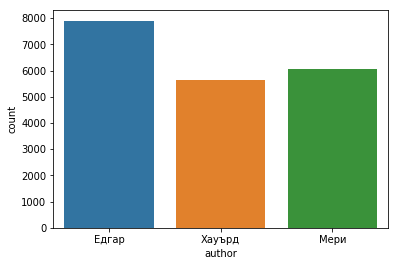

In [5]:
%matplotlib inline
sns.countplot(data=train, x='author');

In [6]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
print("Most used words")
all_words.head(15)

Most used words


the     33296
of      20851
and     17059
to      12615
I       10382
a       10359
in       8787
was      6440
that     5988
my       5037
had      4324
with     4207
his      3802
as       3528
he       3422
dtype: int64

In [7]:
eap = train[train.author=="Едгар"].text.values
hpl = train[train.author=="Хауърд"].text.values
mws = train[train.author=="Мери"].text.values

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score

In [9]:
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', LinearSVC())
])

cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3)

array([ 0.78783701,  0.79635305,  0.79509579])

In [10]:
from sklearn.naive_bayes import MultinomialNB

In [11]:
clf = MultinomialNB()
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))
])

cross_val_score(pipeline, train.text, train.author, scoring='neg_log_loss', cv=3, n_jobs=3)

array([-0.48631897, -0.4762863 , -0.479489  ])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [13]:
pipeline = Pipeline([
    ('features', TfidfVectorizer()),
    ('clf', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))
])

cross_val_score(pipeline, train.text, train.author, scoring='neg_log_loss', cv=3, n_jobs=3)

array([-0.62277497, -0.62149725, -0.61790357])

In [14]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV

#nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)

params_count_word = {"features__ngram_range": [(1,2), (1,3), (2, 3)],
                      "features__analyzer": ['word'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1 , 0.05],
                      "features__min_df":[2, 3, 5, 7, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}

params_count_char = {"features__ngram_range": [(1,4), (1,5), (1,6), (2, 5), (2, 6), (3, 5), (3, 6)],
                      "features__analyzer": ['char'],
                      "features__max_df":[1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1 , 0.05],
                      "features__min_df":[2, 3, 5, 7, 10],
                      "features__lowercase": [False, True],
                      "features__stop_words": [None, stopwords]}
def report(results, n_top=5):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

def random_search():
    params = {
        "clf__alpha": [0.01, 0.1, 0.5, 1, 2]
    }

    params.update(params_count_word)

    pipeline = Pipeline([
        ('features', CountVectorizer()),
        ('clf', MultinomialNB())
    ])

    random_search = RandomizedSearchCV(pipeline, param_distributions=params, 
                                       scoring='neg_log_loss',
                                       n_iter=20, cv=3, n_jobs=4)

    random_search.fit(train.text, train.author)
    report(random_search.cv_results_)

    


[nltk_data] Downloading package stopwords to /home/alex/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', '

In [15]:
random_search()
pipeline = Pipeline([
    ('features', CountVectorizer()),
    ('clf', MultinomialNB())
])
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=3, 
                      scoring='neg_log_loss'))

Model with rank: 1
Mean validation score: -0.500 (std: 0.009)
Parameters: {'features__ngram_range': (1, 3), 'features__max_df': 0.6, 'clf__alpha': 0.5, 'features__min_df': 3, 'features__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all

In [16]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

nltk.download('punkt')
def stemming_tokenizer(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]

pipeline = Pipeline([
    ('features', CountVectorizer(ngram_range=(1, 2),
                                 min_df=2,
                                 max_df=0.8,
                                 lowercase=False,
                                 tokenizer=stemming_tokenizer)),
#                                  stop_words=stopwords.words('english') + list(string.punctuation))),
    ('clf', MultinomialNB(alpha=0.01))
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=5))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=5, 
                      scoring='neg_log_loss'))

[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[ 0.83976716  0.84753295  0.84781609]
[-1.2407899  -1.21859699 -1.23812869]


In [17]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import word_tokenize

nltk.download('punkt')
def stemming_tokenizer(text):
    stemmer = PorterStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]

pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1, 2),
                                 min_df=2,
                                 max_df=0.8,
                                 lowercase=False,
                                 tokenizer=stemming_tokenizer)),
#                                  stop_words=stopwords.words('english') + list(string.punctuation))),
    ('clf', MultinomialNB(alpha=0.01))
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=5))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=5, 
                      scoring='neg_log_loss'))

[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[ 0.84129902  0.84829911  0.8456705 ]
[-0.39106583 -0.38602577 -0.38741785]


In [23]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, LancasterStemmer, ISRIStemmer
from nltk import word_tokenize

nltk.download('punkt')
def stemming_tokenizer(text):
    stemmer = ISRIStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]

pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1, 2),
                                 min_df=2,
                                 max_df=0.8,
                                 lowercase=False,
                                 tokenizer=stemming_tokenizer)),
#                                  stop_words=stopwords.words('english') + list(string.punctuation))),
    ('clf', MultinomialNB(alpha=0.01))
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=8))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=8, 
                      scoring='neg_log_loss'))

[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[ 0.84436275  0.84875881  0.84689655]
[-0.38803888 -0.38472538 -0.38957178]


In [24]:
from sklearn.ensemble import RandomForestClassifier

In [33]:
def stemming_tokenizer(text):
    stemmer = ISRIStemmer()
    return [stemmer.stem(w) for w in word_tokenize(text)]

pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1, 2),
                                 min_df=2,
                                 max_df=0.8,
                                 lowercase=False,
                                 tokenizer=stemming_tokenizer)),
    ('clf', RandomForestClassifier(n_estimators=40, n_jobs=8, random_state=120, max_depth=40, criterion='gini'))
])

print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=8))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=8, 
                      scoring='neg_log_loss'))

[ 0.66283701  0.64817652  0.66099617]
[-0.89955223 -0.90454158 -0.89679078]


In [44]:
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
# Initialize SVD
svd = TruncatedSVD()
    


# We will use logistic regression here..
lr_model = LogisticRegression()


# Create the pipeline 
clf = pipeline.Pipeline([('svd', svd),
                         ('lr', lr_model)])

param_grid = {'svd__n_components' : [120, 180],
              'lr__C': [0.1, 1.0, 10], 
              'lr__penalty': ['l1', 'l2']}

pipeline = Pipeline([
    ('features', TfidfVectorizer(ngram_range=(1, 2),
                                 min_df=2,
                                 max_df=0.8,
                                 lowercase=False,
                                 tokenizer=stemming_tokenizer)),
    ('clf', GridSearchCV(estimator=clf, param_grid=param_grid, scoring='neg_log_loss',
                                 verbose=10, n_jobs=8, iid=True, refit=True, cv=3))
])

#print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=8))
print(cross_val_score(pipeline, train.text, train.author, cv=3, n_jobs=8, 
                      scoring='neg_log_loss'))

Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l1 ................
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l1 ................
Fitting 3 folds for each of 12 candidates, totalling 36 fits


/usr/local/lib/python3.5/dist-packages/sklearn/externals/joblib/parallel.py:547: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  **self._backend_args)


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l1, score=-0.9174739548471665, total=  13.6s


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l1, score=-0.9274827984653506, total=  13.8s


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   13.9s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l1, score=-0.9082483231620134, total=  13.6s


[Parallel(n_jobs=8)]: Done   1 out of   1 | elapsed:   13.7s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l1, score=-0.9181243829255114, total=  12.5s


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   26.4s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l1, score=-0.9181371455212605, total=  12.3s


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   26.4s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l1, score=-0.9214623680409578, total=  12.5s


[Parallel(n_jobs=8)]: Done   2 out of   2 | elapsed:   26.4s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l1, score=-0.9282811303463558, total=  12.6s


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   39.1s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l1, score=-0.9201532738484897, total=  12.6s


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   39.1s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l1, score=-0.9185220879585279, total=  12.5s


[Parallel(n_jobs=8)]: Done   3 out of   3 | elapsed:   39.1s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l1, score=-0.9175860770777683, total=  17.0s


[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:   56.4s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l1, score=-0.9271388049802423, total=  17.3s


[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:   56.7s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l1, score=-0.9079113625376712, total=  18.8s


[Parallel(n_jobs=8)]: Done   4 out of   4 | elapsed:   58.2s remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l1, score=-0.9176840567918837, total=  16.8s


[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l1, score=-0.9189575339529413, total=  17.0s


[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  1.2min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l1, score=-0.9214633193305052, total=  17.8s


[Parallel(n_jobs=8)]: Done   5 out of   5 | elapsed:  1.3min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l1 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l1, score=-0.9311353508638641, total=  16.8s


[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l1, score=-0.920007672465314, total=  16.3s


[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:  1.5min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l1, score=-0.9178654633035175, total=  18.0s


[Parallel(n_jobs=8)]: Done   6 out of   6 | elapsed:  1.6min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l2, score=-0.9758332225305264, total=  10.6s


[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l2, score=-0.9726276343977142, total=  11.0s


[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:  1.7min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l2, score=-0.9702510838634367, total=  11.2s


[Parallel(n_jobs=8)]: Done   7 out of   7 | elapsed:  1.8min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l2, score=-0.9695390424598719, total=  11.1s
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l2, score=-0.9738933333969855, total=  10.6s


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l2 ................
[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l2, score=-0.969903617889489, total=  10.7s


[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:  1.9min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=120, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l2, score=-0.9699208092324847, total=  10.6s


[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:  2.1min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l2, score=-0.9747477176392872, total=  11.4s


[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:  2.1min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=120, lr__penalty=l2, score=-0.9689996424544572, total=  11.9s


[Parallel(n_jobs=8)]: Done   9 out of   9 | elapsed:  2.2min remaining:    0.0s


[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l2, score=-0.9688760420973849, total=  15.6s
[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l2, score=-0.967040323960806, total=  16.6s
[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l2, score=-0.9642452613363007, total=  18.6s
[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l2, score=-0.9635522493922293, total=  18.7s
[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l2, score=-0.9685069125819684, total=  17.3s
[CV] lr__C=0.1, svd__n_components=180, lr__penalty=l2 ................
[CV]  lr__C=0.1, svd__n_components=180, lr__penalty=l2, score=-0.9658358952441434, total= 

[CV] lr__C=10, svd__n_components=120, lr__penalty=l1 .................
[CV]  lr__C=10, svd__n_components=120, lr__penalty=l1, score=-0.7187000003667421, total=  13.1s
[CV] lr__C=10, svd__n_components=120, lr__penalty=l1 .................
[CV]  lr__C=10, svd__n_components=120, lr__penalty=l1, score=-0.7089932289205477, total=  11.8s
[CV] lr__C=10, svd__n_components=180, lr__penalty=l1 .................
[CV]  lr__C=10, svd__n_components=120, lr__penalty=l1, score=-0.7389254313586469, total=  11.9s
[CV] lr__C=10, svd__n_components=180, lr__penalty=l1 .................
[CV]  lr__C=10, svd__n_components=120, lr__penalty=l1, score=-0.7209625670660275, total=  12.8s
[CV] lr__C=10, svd__n_components=120, lr__penalty=l1 .................
[CV]  lr__C=10, svd__n_components=120, lr__penalty=l1, score=-0.7208366299176455, total=  14.7s
[CV] lr__C=10, svd__n_components=180, lr__penalty=l1 .................
[CV]  lr__C=10, svd__n_components=180, lr__penalty=l1, score=-0.6624891748006169, total=  17.4

[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  9.0min finished


[CV]  lr__C=10, svd__n_components=180, lr__penalty=l2, score=-0.6623347979393926, total=  18.2s


[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  9.0min finished


[CV]  lr__C=10, svd__n_components=180, lr__penalty=l2, score=-0.6894158005514163, total=  17.7s
[CV] lr__C=10, svd__n_components=180, lr__penalty=l2 .................
[CV]  lr__C=10, svd__n_components=180, lr__penalty=l2, score=-0.6630880573688971, total=  18.5s


[Parallel(n_jobs=8)]: Done  36 out of  36 | elapsed:  9.3min finished


[-0.6551318  -0.66593556 -0.65790207]
